In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearnex import patch_sklearn

patch_sklearn()

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from keras.layers import Dense
from keras.models import Sequential
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Importação e análise dos conjuntos de dados

In [2]:
SELECTED_DATABASE = "cbis-ddsm"

try:
    breast_cancer_df = pd.read_csv(f"../../outputs/mamografia/{SELECTED_DATABASE}/first_order_features_roi_{SELECTED_DATABASE}.csv")
    aux = pd.read_csv(f"../../outputs/mamografia/{SELECTED_DATABASE}/glcm_features_roi_{SELECTED_DATABASE}.csv")
    breast_cancer_df = pd.concat([breast_cancer_df.drop(columns='pathology'), aux], axis=1)
except FileNotFoundError:
    raise Exception("Database not found!")

breast_cancer_df.head()

,mean,std,variance,skewness,kurtosis,central_moment,dissimilarity_dist_1_ang_0,dissimilarity_dist_1_ang_45,dissimilarity_dist_1_ang_90,dissimilarity_dist_1_ang_135,...,contrast_dist_1_ang_135,ASM_dist_1_ang_0,ASM_dist_1_ang_45,ASM_dist_1_ang_90,ASM_dist_1_ang_135,energy_dist_1_ang_0,energy_dist_1_ang_45,energy_dist_1_ang_90,energy_dist_1_ang_135,pathology
0,5.162631,35.914040,1289.81820,0.001823,-2.999997,315585.9700,0.020211,0.036518,0.023277,0.036408,...,9.284092,0.960235,0.960164,0.960230,0.960164,0.979916,0.979879,0.979913,0.979880,malignant
1,3.968447,31.562720,996.20526,0.002003,-2.999996,246125.5800,0.017001,0.029765,0.021406,0.032605,...,8.314218,0.969282,0.969226,0.969270,0.969215,0.984521,0.984493,0.984515,0.984487,malignant
2,4.139772,32.225830,1038.50400,0.001914,-2.999996,256220.1900,0.020448,0.032512,0.017128,0.028875,...,7.363006,0.967968,0.967914,0.967985,0.967929,0.983853,0.983826,0.983862,0.983834,benign
3,5.079918,35.631073,1269.57350,0.001648,-2.999997,310842.5600,0.019045,0.035339,0.021155,0.031846,...,8.120711,0.960864,0.960794,0.960861,0.960807,0.980237,0.980201,0.980235,0.980208,benign
4,0.192047,6.995360,48.93506,0.009729,-2.999905,12459.6455,0.004702,0.007583,0.004993,0.007000,...,1.784981,0.998476,0.998464,0.998475,0.998467,0.999238,0.999232,0.999237,0.999233,benign_without_callback


Visualizar a frequência das classes

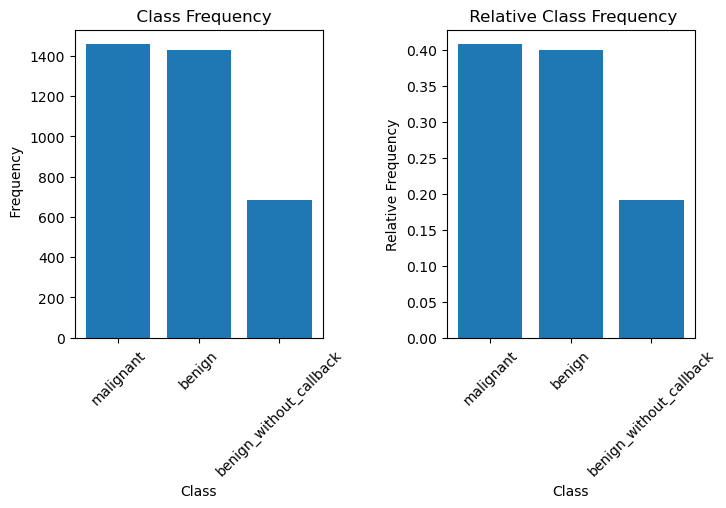

In [3]:
fig = plt.figure(figsize=(8, 4))
titles = ['', 'Relative']

for i, title in enumerate(titles, start=1):
    isRelative = True if i == 2 else False
    frequency = breast_cancer_df['pathology'].value_counts(normalize=isRelative)
    plt.subplot(1, 2, i)
    plt.bar(frequency.index, frequency)
    plt.title(f' {title} Class Frequency')
    plt.xlabel('Class'), plt.ylabel(f'{title} Frequency')
    plt.xticks(rotation=45)
fig.subplots_adjust(wspace=0.5)
plt.show()

### Pré-Processamento

In [4]:
# Elimina os dados com classe BENIGN_WITHOUT_CALLBACK ou NORMAL
breast_cancer_df = breast_cancer_df[breast_cancer_df["pathology"] != "benign_without_callback"]
breast_cancer_df = breast_cancer_df[breast_cancer_df["pathology"] != "normal"]

# Elimina os dados com valores nulos
breast_cancer_df.dropna(inplace=True)

# Separa em features e labels
X, y = (breast_cancer_df.drop(["pathology"], axis=1), breast_cancer_df["pathology"])

# Tratamos os rótulos categóricos
y = y.map({"benign": 0, "malignant": 1})

# Balanceamento dos dados
if SELECTED_DATABASE in ["inbreast", "mias"]:
    smote = SMOTE()
    X, y = smote.fit_resample(X, y)
elif SELECTED_DATABASE == "cmmd":
    nearmiss = NearMiss(version=1)
    X, y = nearmiss.fit_resample(X, y)

# Separa os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

# Padroniza os dados
for col in X_train.columns:
    scaler = MinMaxScaler()
    X_train[col] = scaler.fit_transform(X_train[col].values.reshape(-1, 1))
    X_test[col] = scaler.transform(X_test[col].values.reshape(-1, 1))

##### Visualizar Dados após pré-processamento 

In [5]:
X_train.head()

,mean,std,variance,skewness,kurtosis,central_moment,dissimilarity_dist_1_ang_0,dissimilarity_dist_1_ang_45,dissimilarity_dist_1_ang_90,dissimilarity_dist_1_ang_135,...,contrast_dist_1_ang_90,contrast_dist_1_ang_135,ASM_dist_1_ang_0,ASM_dist_1_ang_45,ASM_dist_1_ang_90,ASM_dist_1_ang_135,energy_dist_1_ang_0,energy_dist_1_ang_45,energy_dist_1_ang_90,energy_dist_1_ang_135
2231,0.006545,0.173090,0.035287,0.203947,0.012464,0.566805,0.006116,0.006954,0.005452,0.006554,...,0.218978,0.216469,0.988392,0.988357,0.988395,0.988364,0.994049,0.994041,0.994054,0.994046
984,0.437552,0.500348,0.259652,0.096034,0.000685,0.474796,0.300509,0.386831,0.381399,0.398371,...,0.151482,0.167429,0.012314,0.011459,0.011544,0.011430,0.092884,0.090216,0.089813,0.090302
1635,0.003780,0.127622,0.020431,0.251960,0.027530,0.542641,0.003407,0.003608,0.003249,0.003565,...,0.130490,0.117730,0.993281,0.993266,0.993280,0.993267,0.996560,0.996558,0.996561,0.996559
945,0.000817,0.051181,0.004427,0.430058,0.132995,0.516342,0.000996,0.001400,0.001309,0.001608,...,0.052562,0.053095,0.998541,0.998531,0.998536,0.998528,0.999254,0.999250,0.999252,0.999249
2376,0.002900,0.109769,0.015686,0.265704,0.033009,0.534873,0.003687,0.004323,0.003481,0.003960,...,0.139826,0.130781,0.994827,0.994804,0.994826,0.994811,0.997352,0.997345,0.997354,0.997349


##### Visualizar frequência de classe em cada parte do conjunto de dados

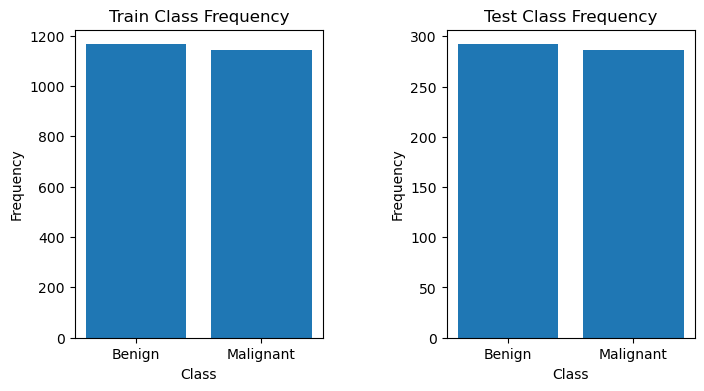

In [6]:
fig = plt.figure(figsize=(8, 4))
y_parts = [y_train, y_test]
idxs = [1, 2]
titles = ['Train', 'Test']

for i, y_part, title in zip(idxs, y_parts, titles):
    frequency = y_part.value_counts()
    frequency.index = ['Benign', 'Malignant']
    
    plt.subplot(1, 2, i)
    plt.bar(frequency.index, frequency)
    plt.title(f'{title} Class Frequency')
    plt.xlabel('Class'), plt.ylabel('Frequency')
fig.subplots_adjust(wspace=0.5)
plt.show()

### Treinamento dos modelos

##### Funções

In [7]:
# Função para criar o modelo do Keras
def create_mlp_model(shape):
    model = Sequential()
    model.add(Dense(25, input_dim=shape, activation="relu"))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    return model

##### Treino dos modelos

In [8]:
# Models
random_forest_model = RandomForestClassifier(n_estimators=120, max_depth=10, criterion="gini", 
                                             min_samples_leaf=3, min_samples_split=2)
boosted_tree_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=100)
mlp_model = create_mlp_model(X_train.shape[1])

threshold = 0.5
titles = ["Random Forest", "Boosted Tree", "MLP"]
models = [random_forest_model, boosted_tree_model, mlp_model]
scores = {}

for model, title in zip(models, titles):
    predict = []
    if title == "MLP":
        model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0)
        predict = model.predict(X_test)
        predict = (predict > threshold).astype(int) # Transformar as saídas em rótulos
    else:
        model.fit(X_train, y_train)
        predict = model.predict(X_test)

    scores[title] = {"accuracy_score": accuracy_score(y_test, predict) * 100}
    scores[title]["precision_score"] = precision_score(y_test, predict) * 100
    scores[title]["recall_score"] = recall_score(y_test, predict) * 100
    scores[title]["f1_score"] = f1_score(y_test, predict) * 100

19/19 [==============================] - 0s 2ms/step


### Avaliação dos modelos

In [9]:
scores_df = pd.DataFrame(scores).T
scores_df

,accuracy_score,precision_score,recall_score,f1_score
Random Forest,59.688581,61.847390,52.739726,56.931608
Boosted Tree,58.304498,59.770115,53.424658,56.419530
MLP,56.747405,71.428571,23.972603,35.897436


In [10]:
result = [[58.304498, 57.439446, 56.401384]]

columns=['Random Forest', 'Boosted Tree', 'MLP']
df = pd.DataFrame(result, columns=columns)

def mean_without_extremes(df):
    new_df = pd.DataFrame(columns=df.columns)
    for col in df.columns:
        df.sort_values(by=col, inplace=True)
        df[col] = df[col].drop(df[col].index[[0, -1]])
        new_df[col] = [df[col].mean()]
    return new_df

df = mean_without_extremes(df)
df

,Random Forest,Boosted Tree,MLP
0,NaN,NaN,NaN
